In [ ]:
# ---------------------------------------------------------------------
# 0. Imports (dolfinx 0.9.x)
# ---------------------------------------------------------------------
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import pyvista
import imageio
from dolfinx import mesh, fem, la
from ufl import FacetNormal
from ufl import dot, grad, dx, ds, inner
import dolfinx.fem.petsc    # assemble / lifting helpers

# ---------------------------------------------------------------------
# 1. Mesh and P1 function space
# ---------------------------------------------------------------------
comm        = MPI.COMM_WORLD
Nx, Ny      = 64, 64
domain      = mesh.create_unit_square(comm, Nx, Ny, mesh.CellType.triangle)
V           = fem.functionspace(domain, ("Lagrange", 1))

# ---------------------------------------------------------------------
# 2. Homogeneous Dirichlet boundary (u = 0 on ∂Ω)
# ---------------------------------------------------------------------
def boundary_indicator(x):
    return np.isclose(x[0], 0) | np.isclose(x[0], 1) \
        |  np.isclose(x[1], 0) | np.isclose(x[1], 1)

fdim            = domain.topology.dim - 1
facets          = mesh.locate_entities_boundary(domain, fdim, boundary_indicator)
dofs            = fem.locate_dofs_topological(V, fdim, facets)
zero            = fem.Constant(domain, PETSc.ScalarType(0))
bc              = fem.dirichletbc(zero, dofs, V)      # 👉 wrapper‑safe BC

# ---------------------------------------------------------------------
# 3. Initial condition  u⁰(x,y) = exp(-100·|(x,y)-(0.5,0.5)|²)
# ---------------------------------------------------------------------
u_prev = fem.Function(V, name="u_prev")
dof_xy = V.tabulate_dof_coordinates()        # (ndofs, 2)
r2     = (dof_xy[:, 0] - 0.5)**2 + (dof_xy[:, 1] - 0.5)**2
u_prev.x.array[:] = np.exp(-100.0 * r2)
u_prev.x.scatter_forward()


# ---------------------------------------------------------------------
# 4. Weak forms for implicit Euler
#     (u, v) + Δt (∇u, ∇v)  =  (u_prev, v)     ( RHS has f = 0 )
# ---------------------------------------------------------------------

# Physical parameters (you choose these)
D_value  = .1       # diffusion coefficient
dt_value = 5e-5      # time step size
v0x, v0y = -40.0, 0.0   # constant advection velocity components


# 4. Define trial‐ and test‐ functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# 4a. Physical parameters
D  = dolfinx.fem.Constant(domain, D_value)
dt = dolfinx.fem.Constant(domain, dt_value)
v0 = dolfinx.fem.Constant(domain, (v0x, v0y))

# 4b. Outward normal (for the boundary integral)
n = FacetNormal(domain)

# 4c. Build the bilinear form a(u,v)
a_varform = (
      u * v                       #   ∫Ω u^{n+1} · v
    + D * dt * dot(grad(u), grad(v))     # + ∫Ω D Δt ∇u^{n+1}·∇v
    - dt * dot(v0, grad(u)) * v          # - ∫Ω Δt (v0·∇u^{n+1}) v
) * dx
# and then the outflow boundary term:
a_varform += dt * (dot(v0, n) * u * v) * ds

# 4d. Build the right‐hand side form L(v)
L_varform = (u_prev * v) * dx           # ∫Ω u^n v

# Finally compile them once
a_form = dolfinx.fem.form(a_varform)
L_form = dolfinx.fem.form(L_varform)

# ---------------------------------------------------------------------
# 5. Assemble once (matrix & RHS container) – uses la.* API
# ---------------------------------------------------------------------
A_mat  = dolfinx.fem.petsc.assemble_matrix((a_form), bcs=[])   # la.MatrixCSR
A_mat.assemble()
b_vec  = dolfinx.fem.petsc.assemble_vector((L_form))               # la.Vector
# NOTE: no explicit .assemble() is needed – la.assemble_matrix already
# fills & finalizes the PETSc matrix internally.

# ---------------------------------------------------------------------
# 6. PETSc linear solver (CG + SOR) – takes la.MatrixCSR directly
# ---------------------------------------------------------------------
ksp = PETSc.KSP().create(comm)
ksp.setOperators(A_mat)                         # accepted in 0.9
ksp.setType(PETSc.KSP.Type.CG)
ksp.getPC().setType(PETSc.PC.Type.SOR)


# ---------------------------------------------------------------------
# 7. Time stepping
# ---------------------------------------------------------------------
u_curr   = fem.Function(V, name="u_curr")
t_finu_curr   = fem.Function(V, name="u_curr")
t_final  = 0.05
n_steps  = int(t_final / dt_value)

answers : list[dolfinx.fem.function.Function] = []
pngs = [] 
for step in range(1, n_steps + 1):
    # Assemble RHS (b_vec) for the current step
    with b_vec.localForm() as loc:
        loc.set(0.0)

    dolfinx.fem.petsc.assemble_vector(b_vec, L_form)
    dolfinx.fem.petsc.apply_lifting(b_vec, [a_form], bcs=[[]])            # account for BCs
    b_vec.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,
                      mode =PETSc.ScatterMode.REVERSE)
    dolfinx.fem.set_bc(b_vec, [])                                   # enforce BCs in RHS

    # Solve  A u_curr = b
    ksp.solve(b_vec, u_curr.x.petsc_vec)                   # all PETSc objects
    u_curr.x.scatter_forward()

    # Prepare for next step
    u_prev.x.array[:] = u_curr.x.array
     
    
    if step % 2 == 0:
        # build a PyVista mesh & warp it by the solution
        topo, cells, xyz = dolfinx.plot.vtk_mesh(u_curr.function_space)
        grid = pyvista.UnstructuredGrid(topo, cells, xyz)
        grid.point_data["u"] = u_curr.x.array
        grid.set_active_scalars("u")

        # off―screen rendering
        pl = pyvista.Plotter(off_screen=True, window_size=(400,400))
        pl.add_mesh(grid, show_edges=True, clim = [0, 0.5])
        #pl.view_xy()
        pl.view_isometric()
        img = pl.screenshot()
        pngs.append(img)
        pl.close()

    

    if comm.rank == 0 and step % 10 == 0:
        print(f"step {step:3d}/{n_steps},   t = {step*dt_value:6.4f}")

# ----------------------------------------------------a-----------------
# 8. Write final solution (optional)
# ---------------------------------------------------------------------

print(len(pngs))

if comm.rank == 0:
    with imageio.get_writer("v2_iso_animation.gif", mode = "I", fps=10) as writer:
        for fn in pngs:
            writer.append_data(fn)
    print("Wrote v2animation.gif")


step  10/1000,   t = 0.0005
step  20/1000,   t = 0.0010
step  30/1000,   t = 0.0015
step  40/1000,   t = 0.0020
step  50/1000,   t = 0.0025
step  60/1000,   t = 0.0030
step  70/1000,   t = 0.0035
step  80/1000,   t = 0.0040
step  90/1000,   t = 0.0045
step 100/1000,   t = 0.0050
step 110/1000,   t = 0.0055
step 120/1000,   t = 0.0060
step 130/1000,   t = 0.0065
step 140/1000,   t = 0.0070
step 150/1000,   t = 0.0075
step 160/1000,   t = 0.0080
step 170/1000,   t = 0.0085
step 180/1000,   t = 0.0090
step 190/1000,   t = 0.0095
step 200/1000,   t = 0.0100
step 210/1000,   t = 0.0105
step 220/1000,   t = 0.0110
step 230/1000,   t = 0.0115
step 240/1000,   t = 0.0120
step 250/1000,   t = 0.0125
step 260/1000,   t = 0.0130
step 270/1000,   t = 0.0135
step 280/1000,   t = 0.0140
step 290/1000,   t = 0.0145
step 300/1000,   t = 0.0150
step 310/1000,   t = 0.0155
step 320/1000,   t = 0.0160
step 330/1000,   t = 0.0165
step 340/1000,   t = 0.0170
step 350/1000,   t = 0.0175
step 360/1000,   t =

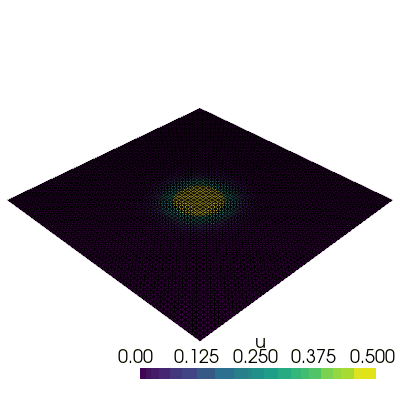

In [79]:
from IPython.display import Image, display
display(Image(filename="v2_iso_animation.gif"))

